In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import chi2_contingency, chisquare
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings('ignore')
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, RocCurveDisplay,auc)


Bad key text.latex.preview in file D:\An\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file D:\An\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file D:\An\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably need 

In [2]:
def get_pred(prob,cutoff):
    #a = tpr + (1 - fpr)
    pred = np.where(prob > cutoff, 1, 0)
    return pred

In [3]:
dataFile = 'D:\\yyzxrj\\project\\Training dataset for running.xlsx'
data = pd.read_excel(dataFile)
x_train, y_train = data.iloc[:,0:-1], data.iloc[:,-1]

In [7]:
dataFile = 'D:\\yyzxrj\\project\\External test set for running.xlsx'
data = pd.read_excel(dataFile)
x_test, y_test = data.iloc[:,0:-1], data.iloc[:,-1]

In [9]:
def search_model(clf,param,x_train,y_train):
    model = GridSearchCV(clf,param,cv=5,scoring='accuracy')
    model = model.fit(x_train,y_train)
    scores = model.best_score_
    params = model.best_params_
    print(scores,params)

In [11]:
classifiers = [RandomForestClassifier(random_state=0,max_depth=9,n_jobs=-1)]
parameters = [{'n_estimators':range(1,300,1)}]
for clf,param in zip(classifiers,parameters):
    search_model(clf,param,x_train,y_train) 

0.7299584631360332 {'n_estimators': 248}


In [12]:
classifier = RandomForestClassifier(random_state=0,
                                    n_estimators=248,
                                    max_depth=9,
                                    class_weight='balanced_subsample',
                                    oob_score=True,
                                    max_features='sqrt',
                                    min_samples_split=3,            
                                    min_samples_leaf=1,
                                    n_jobs=-1)
classifier.fit(x_train,y_train)
y_prob_train = classifier.predict_proba(x_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)
best_threshold = thresholds[np.argmax(tpr - fpr)]

y_prob_test = classifier.predict_proba(x_test)[:,1]
y_pred_train = get_pred(y_prob_train,best_threshold)
y_pred_test = get_pred(y_prob_test,best_threshold)

tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()


Train_sensitivity = tp / (tp + fn)  # SEN
Train_specificity = tn / (tn + fp)  # SPE
Train_ppv = tp / (tp + fp)          # PPV
Train_npv = tn / (tn + fn)          # NPV
Train_accuracy = (tp + tn) / (tn + tp + fn + fp)    #ACC
metrics = {
    'Train_sensitivity': Train_sensitivity,
    'Train_specificity': Train_specificity,
    'Train_ppv': Train_ppv,
    'Train_npv': Train_npv,
    'Train_accuracy':Train_accuracy
}

print("model performance indicators:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

model performance indicators:
Train_sensitivity: 0.8962
Train_specificity: 0.9577
Train_ppv: 0.9833
Train_npv: 0.7684
Train_accuracy: 0.9125


In [30]:
joblib.dump(classifier, 'rfc.pkl')

['rfc.pkl']

In [21]:
model_forest = joblib.load('D:\\yyzxrj\\rfc.pkl') 
y_prob_test = classifier.predict_proba(x_test)[:,1]
y_pred_test = get_pred(y_prob_test,best_threshold)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()


test_sensitivity = tp / (tp + fn) 
test_specificity = tn / (tn + fp)  
test_ppv = tp / (tp + fp)         
test_npv = tn / (tn + fn)          
test_accuracy = (tp + tn) / (tn + tp + fn + fp)   
metrics = {
    'test_Sensitivity': test_sensitivity,
    'test_Specificity': test_specificity,
    'test_PPV': test_ppv,
    'test_NPV': test_npv,
    'test_accuracy':test_accuracy
}

print("model performance indicators:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

model performance indicators:
test_Sensitivity: 0.8857
test_Specificity: 0.7529
test_PPV: 0.9118
test_NPV: 0.6957
test_accuracy: 0.8515


In [101]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

def calculate_auc_ci(x_data, y_true, classifier, n_boot=1000, confidence_level=0.95):
    
   
    y_true = np.asarray(y_true)
    assert set(y_true).issubset({0,1}), 
    
   
    y_score = classifier.predict_proba(x_data)[:, 1]
    auc_value = roc_auc_score(y_true, y_score)
    
    
    auc_scores = []
    
    for i in range(n_boot):
        
        x_resampled, y_resampled = resample(x_data, y_true, random_state=i)
        
        
        y_score_resampled = classifier.predict_proba(x_resampled)[:, 1]
        
       
        auc_boot = roc_auc_score(y_resampled, y_score_resampled)
        auc_scores.append(auc_boot)
    
    
    alpha = (1 - confidence_level) / 2
    ci_lower = np.percentile(auc_scores, alpha * 100)
    ci_upper = np.percentile(auc_scores, (1 - alpha) * 100)
    
    
    y_true_distribution = {
        'total_samples': len(y_true),
        'class_0_count': np.sum(y_true == 0),
        'class_1_count': np.sum(y_true == 1),
        'class_0_ratio': np.mean(y_true == 0),
        'class_1_ratio': np.mean(y_true == 1)
    }
    
    return {
        'AUC': {'estimate': auc_value, '95% CI': [ci_lower, ci_upper]},
        'y_true_info': y_true_distribution,
        'y_true_values': y_true
    }

def calculate_auc_ci_comprehensive(classifier, x_train, y_train, x_test, y_test, n_boot=1000):
   
    train_result = calculate_auc_ci(x_train, y_train, classifier, n_boot)
    test_result = calculate_auc_ci(x_test, y_test, classifier, n_boot)
    
    return {
        'train_auc': train_result['AUC'],
        'test_auc': test_result['AUC'],
        'train_info': train_result['y_true_info'],
        'test_info': test_result['y_true_info']
    }



auc_results = calculate_auc_ci_comprehensive(
    classifier, x_train, y_train, x_test, y_test, n_boot=1000
)

print("=" * 60)
print("AUC Performance Analysis Report")
print("=" * 60)
print(f"Training Set AUC: {auc_results['train_auc']['estimate']:.4f} "
      f"(95% CI: {auc_results['train_auc']['95% CI'][0]:.4f}-{auc_results['train_auc']['95% CI'][1]:.4f})")
print(f"Test Set AUC: {auc_results['test_auc']['estimate']:.4f} "
      f"(95% CI: {auc_results['test_auc']['95% CI'][0]:.4f}-{auc_results['test_auc']['95% CI'][1]:.4f})")

AUC Performance Analysis Report
Training Set AUC: 0.9840 (95% CI: 0.9749-0.9914)
Test Set AUC: 0.8462 (95% CI: 0.7941-0.8951)


In [25]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix

In [26]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(x_test)


y_prob_test = classifier.predict_proba(x_test)[:, 1]


def get_pred(y_prob, threshold):
    return (y_prob >= threshold).astype(int)


y_pred_test = get_pred(y_prob_test, best_threshold)


tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

print(f"threshold: {best_threshold:.4f}")



sample_index = 114  
class_index = 1   


if isinstance(shap_values, list):
    shap_value_for_sample = shap_values[class_index][sample_index]
else:
    shap_value_for_sample = shap_values[sample_index]

base_value = explainer.expected_value
if isinstance(base_value, np.ndarray):
    base_value = base_value[class_index]


sample_to_explain = x_test.iloc[sample_index] if hasattr(x_test, 'iloc') else x_test[sample_index]
sample_prob = y_prob_test[sample_index]
sample_pred = y_pred_test[sample_index]
sample_true = y_test.iloc[sample_index] if hasattr(y_test, 'iloc') else y_test[sample_index]

threshold: 0.5118


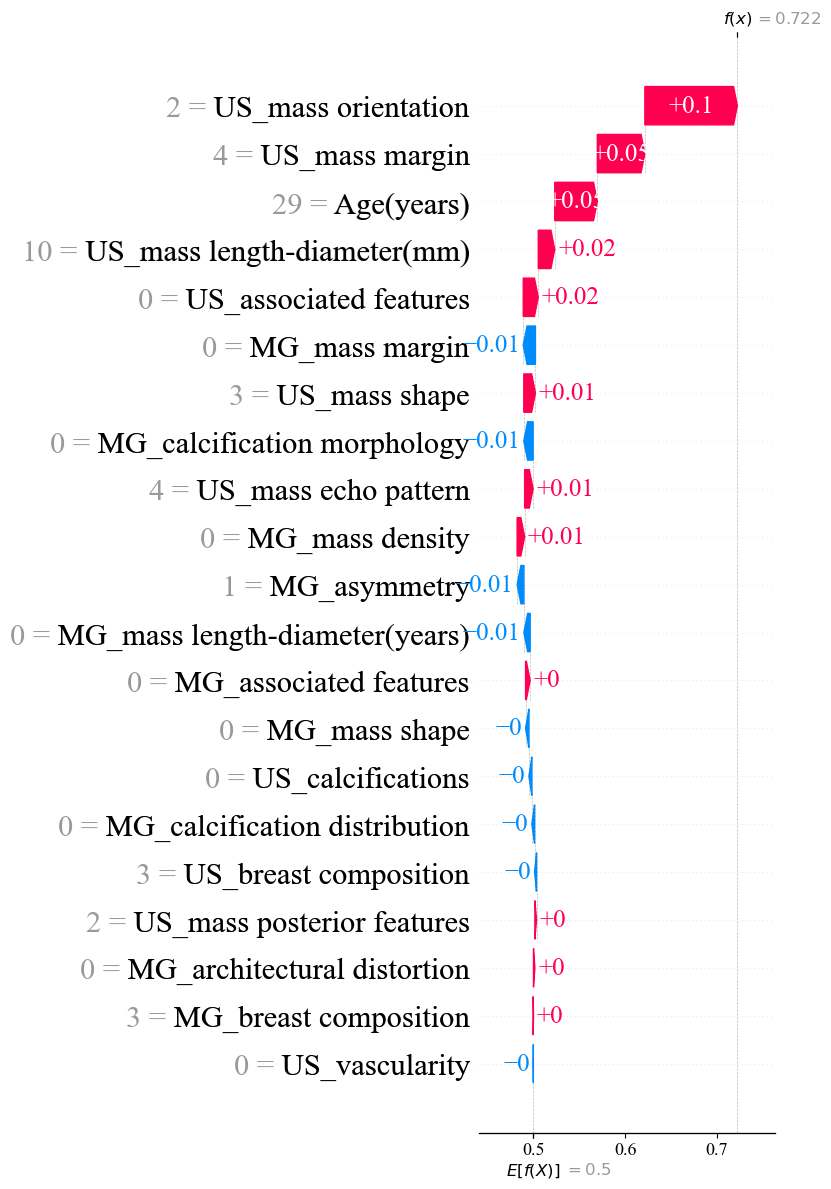

In [28]:
import matplotlib.pyplot as plt
import shap


plt.rcParams['font.family'] = 'Times New Roman'


fig, ax = plt.subplots(figsize=(16, 12))


if hasattr(x_test, 'columns'):
    feature_names = x_test.columns.tolist()
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_value_for_sample,
            base_values=base_value,
            data=sample_to_explain,
            feature_names=feature_names
        ),
        max_display=21,
        show=False
    )
else:
    shap.plots.waterfall(shap_value_for_sample, show=False)


for i, text in enumerate(ax.texts):
    text.set_fontfamily('Times New Roman')
    text.set_fontsize(18)


for label in ax.get_yticklabels():
    label.set_fontfamily('Times New Roman')
    label.set_fontsize(22)

plt.tight_layout()
plt.savefig('D:\\yyzxrj\\project\\picture\\benefit waterfall.png', dpi=600, bbox_inches='tight')
plt.show()

In [31]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(x_test)


y_prob_test = classifier.predict_proba(x_test)[:, 1]


def get_pred(y_prob, threshold):
    return (y_prob >= threshold).astype(int)



y_pred_test = get_pred(y_prob_test, best_threshold)


tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()



sample_index = 161  
class_index = 1   


if isinstance(shap_values, list):
    shap_value_for_sample = shap_values[class_index][sample_index]
else:
    shap_value_for_sample = shap_values[sample_index]

base_value = explainer.expected_value
if isinstance(base_value, np.ndarray):
    base_value = base_value[class_index]


sample_to_explain = x_test.iloc[sample_index] if hasattr(x_test, 'iloc') else x_test[sample_index]
sample_prob = y_prob_test[sample_index]
sample_pred = y_pred_test[sample_index]
sample_true = y_test.iloc[sample_index] if hasattr(y_test, 'iloc') else y_test[sample_index]


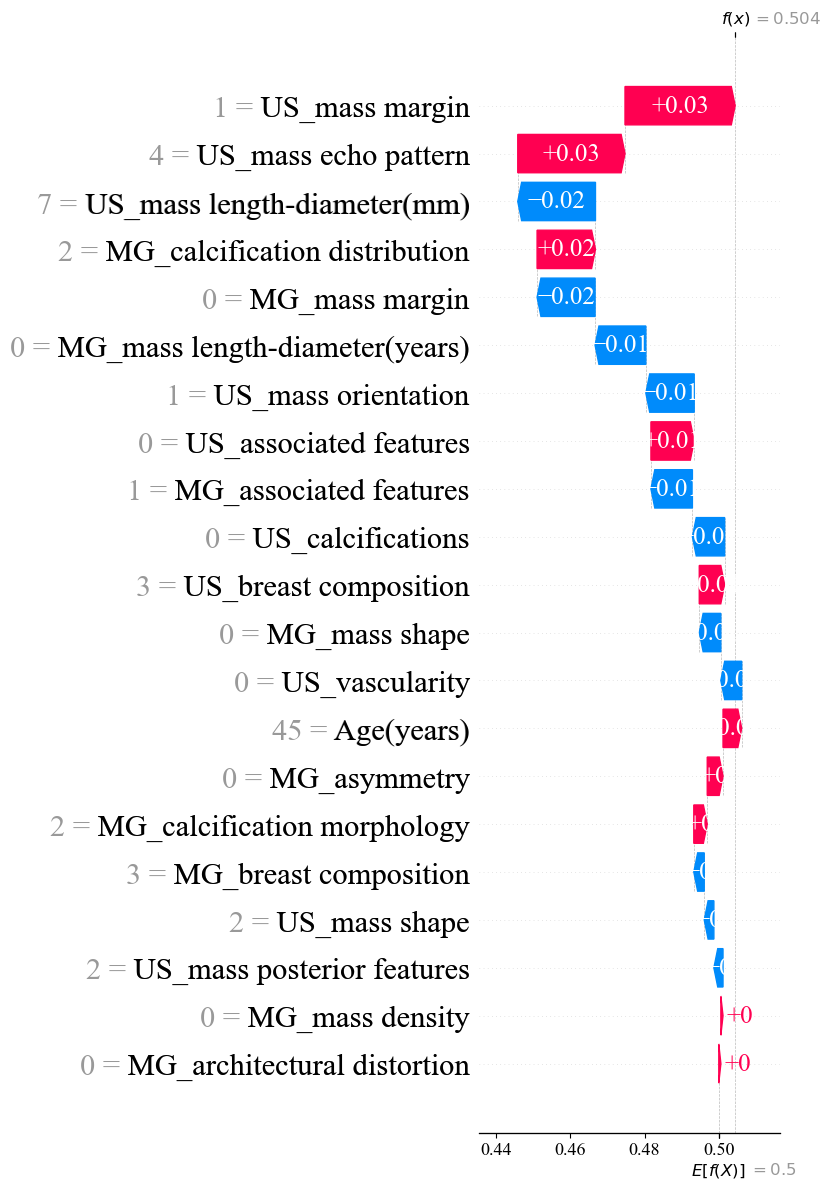

In [32]:
import matplotlib.pyplot as plt
import shap


plt.rcParams['font.family'] = 'Times New Roman'


fig, ax = plt.subplots(figsize=(16, 12))


if hasattr(x_test, 'columns'):
    feature_names = x_test.columns.tolist()
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_value_for_sample,
            base_values=base_value,
            data=sample_to_explain,
            feature_names=feature_names
        ),
        max_display=21,
        show=False
    )
else:
    shap.plots.waterfall(shap_value_for_sample, show=False)


for i, text in enumerate(ax.texts):
    text.set_fontfamily('Times New Roman')
    text.set_fontsize(18)


for label in ax.get_yticklabels():
    label.set_fontfamily('Times New Roman')
    label.set_fontsize(22)

plt.tight_layout()
plt.savefig('D:\\yyzxrj\\project\\picture\\no benefit waterfall.png', dpi=600, bbox_inches='tight')
plt.show()

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [37]:
def net_benefit_model(y_test,y_prob,thresh_group):
    total = y_test.shape[0]
    y_prob = np.array(y_prob)
    net_model = np.array([])
    for thresh in thresh_group:
        
        y_pred_t = [1 if i > thresh else 0 for i in y_prob]
        tn, fp, fn, tp = confusion_matrix(y_test,y_pred_t).ravel()
        net_benefit = tp/total-(fp/total)*(thresh/(1-thresh))
        net_model = np.append(net_model,net_benefit)
    return net_model
 
def net_benefit_all(y_test,thresh_group):
    tn, fp, fn, tp = confusion_matrix(y_test,y_test).ravel()
    total = y_test.shape[0]
    net_all = np.array([])
    for thresh in thresh_group:
        net_benefit = tp/total - (tn/total)*(thresh/(1-thresh))
        net_all = np.append(net_all, net_benefit)
    return net_all

In [39]:
classifier.fit(x_train,y_train)
y_prob_train = classifier.predict_proba(x_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)
best_threshold = thresholds[np.argmax(tpr - fpr)]

y_prob_test = classifier.predict_proba(x_test)[:,1]
y_pred_train = get_pred(y_prob_train,best_threshold)
y_pred_test = get_pred(y_prob_test,best_threshold)

tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The horizontal axis range of the decision curve below the baseline:
No decision curve is higher than or equal to the baseline at all threshold points


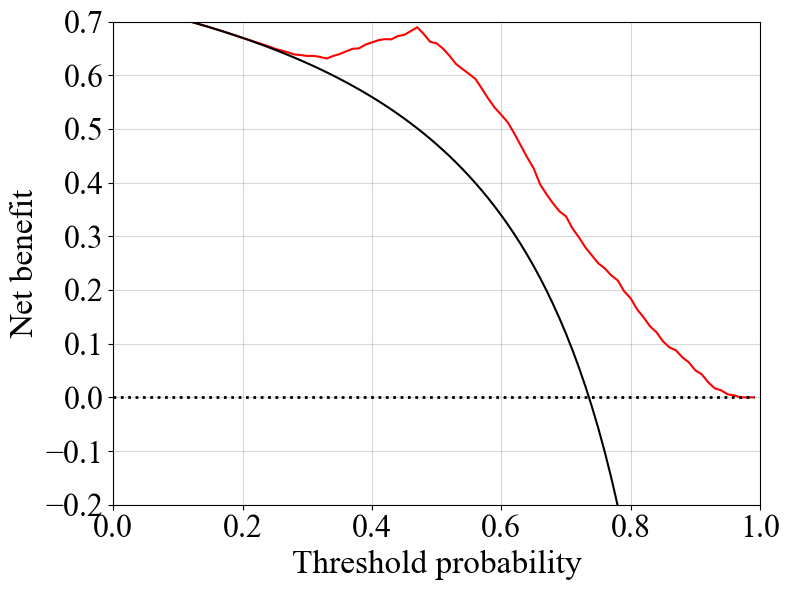

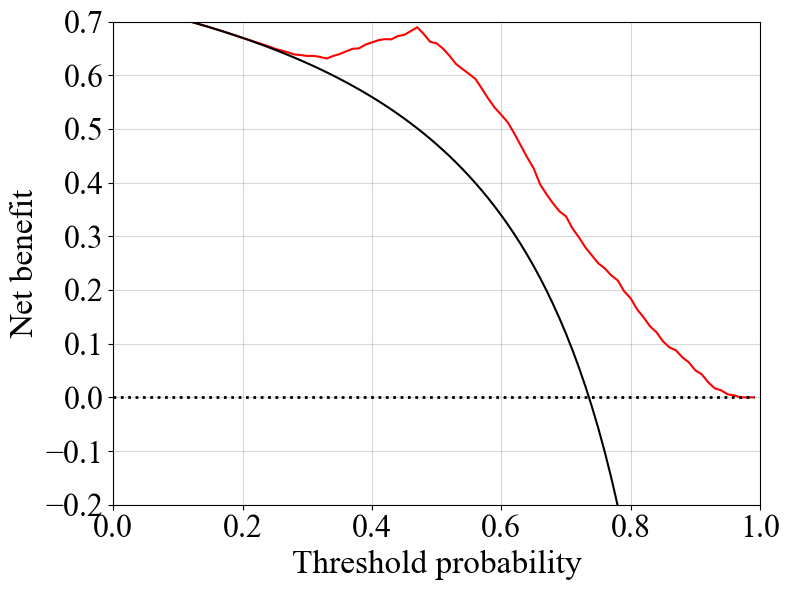

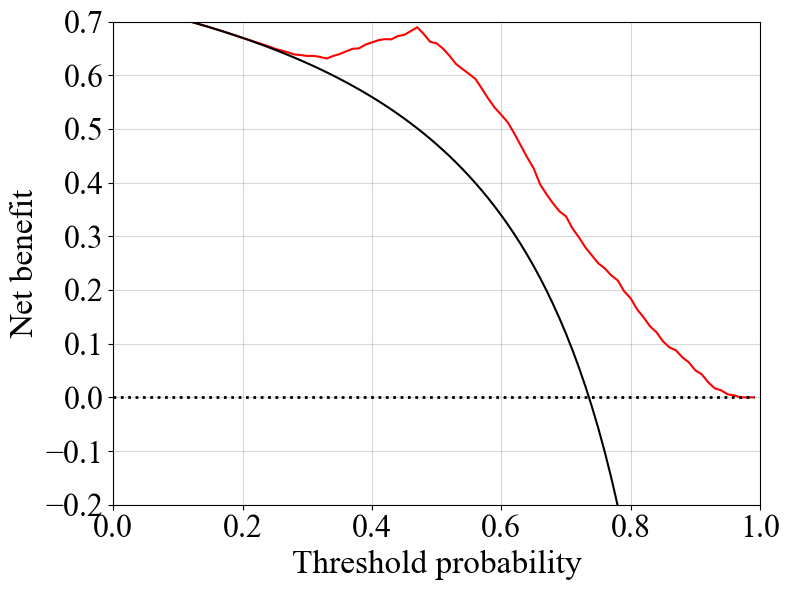

In [49]:
thresh_group = np.arange(0,1,0.01)
fig, ax = plt.subplots(figsize=(8, 6))
color = ["red"]
a = 0
modellist = ['']
problist = [y_prob_train]
benefit_all = net_benefit_all(y_train,thresh_group)
List = []
benefit_models = []
plt.xlim(0,1)
for i in range(len(modellist)):
    benefit_model = net_benefit_model(y_train, problist[i], thresh_group)
    List.append(benefit_model)
    plt.plot(thresh_group, benefit_model, color=color[i], label=modellist[i])


benefit_model = List[0]  
below_baseline = benefit_model < benefit_all


below_ranges = []
start_idx = None

for j in range(len(thresh_group)):
    if below_baseline[j]:
        if start_idx is None:
            start_idx = j
    else:
        if start_idx is not None:
            below_ranges.append((thresh_group[start_idx], thresh_group[j-1]))
            start_idx = None


if start_idx is not None:
    below_ranges.append((thresh_group[start_idx], thresh_group[-1]))


print("The horizontal axis range of the decision curve below the baseline:")
if below_ranges:
    for range_start, range_end in below_ranges:
        print(f"[{range_start:.2f}, {range_end:.2f}]")
else:
    print("No decision curve is higher than or equal to the baseline at all threshold points")


plt.plot(thresh_group, benefit_all, color='black')
plt.plot(thresh_group, np.zeros(len(thresh_group)), color='k', lw=2, linestyle=':')

plt.ylim(-0.2,0.7)
plt.xlabel(
    xlabel = 'Threshold probability', 
    fontdict= {'family': 'Times New Roman', 'fontsize': 24}
)
plt.ylabel(
    ylabel = 'Net benefit', 
    fontdict= {'family': 'Times New Roman', 'fontsize': 24}
)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.grid(True, alpha=0.5)
plt.tight_layout()
#plt.spines['right'].set_color((0.8, 0.8, 0.8))
#plt.spines['top'].set_color((0.8, 0.8, 0.8))
plt.legend(handlelength=0,fontsize=16,loc='upper left',framealpha=0,)
plt.savefig('D:\\yyzxrj\\project\\picture\\Train-decide.png',dpi=600,bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The horizontal axis range of the decision curve below the baseline::
[0.32, 0.32]
[0.61, 0.65]


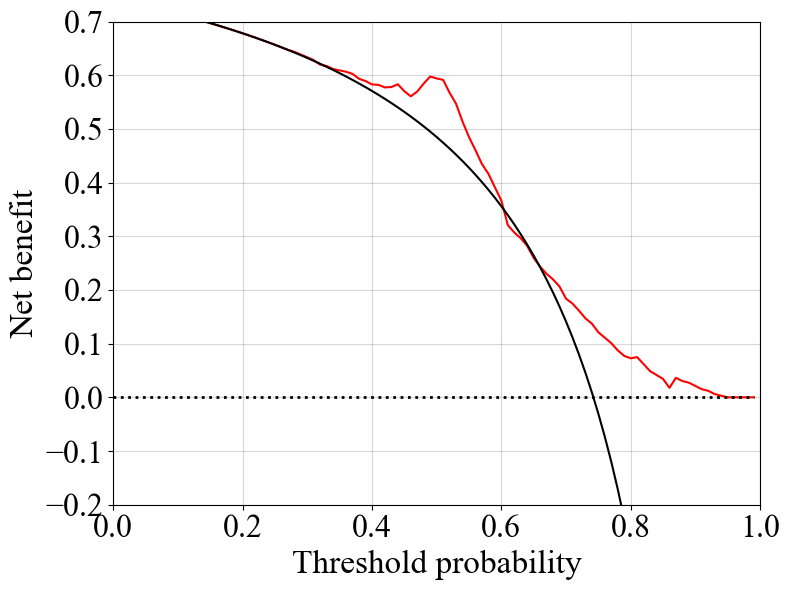

In [51]:
thresh_group = np.arange(0,1,0.01)
fig, ax = plt.subplots(figsize=(8, 6))
color = ["red"]
modellist = ['']
problist = [y_prob_test]
benefit_all = net_benefit_all(y_test,thresh_group)

plt.xlim(0,1)


benefit_model = net_benefit_model(y_test, problist[0], thresh_group)
plt.plot(thresh_group, benefit_model, color=color[0], label=modellist[0])


below_baseline = benefit_model < benefit_all
below_indices = np.where(below_baseline)[0]


if len(below_indices) > 0:
    ranges = []
    start_idx = below_indices[0]
    
    for j in range(1, len(below_indices)):
        if below_indices[j] != below_indices[j-1] + 1:
            ranges.append((thresh_group[start_idx], thresh_group[below_indices[j-1]]))
            start_idx = below_indices[j]
    
    
    ranges.append((thresh_group[start_idx], thresh_group[below_indices[-1]]))
    
    
    print("The horizontal axis range of the decision curve below the baseline::")
    for range_start, range_end in ranges:
        print(f"[{range_start:.2f}, {range_end:.2f}]")
else:
    print("No decision curve is higher than or equal to the baseline at all threshold points")

plt.plot(thresh_group, benefit_all, color='black')
plt.plot(thresh_group, np.zeros(len(thresh_group)), color='k', lw=2, linestyle=':')

plt.ylim(-0.2,0.7)
plt.xlabel(
    xlabel = 'Threshold probability', 
    fontdict= {'family': 'Times New Roman', 'fontsize': 24}
)
plt.ylabel(
    ylabel = 'Net benefit', 
    fontdict= {'family': 'Times New Roman', 'fontsize': 24}
)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.legend(handlelength=0,fontsize=16,framealpha=0,loc='upper left')
plt.savefig('D:\\yyzxrj\\project\\picture\\Test-decide.png',dpi=600,bbox_inches='tight')
plt.show()

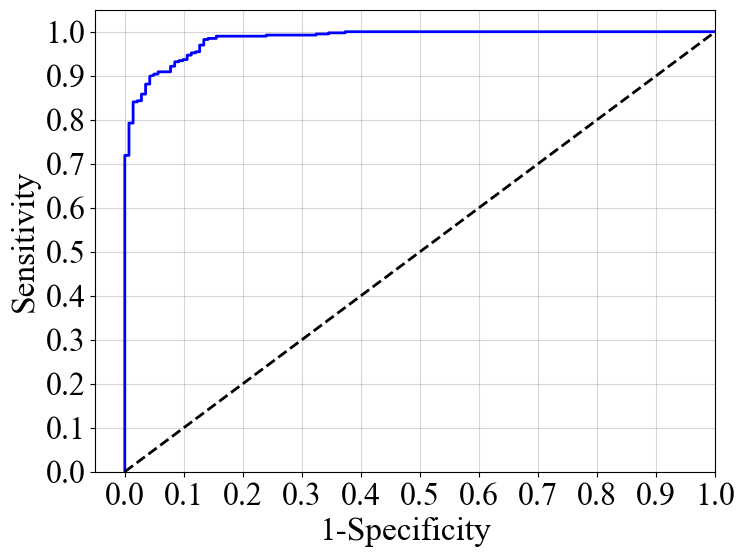

In [53]:
y_prob_train = classifier.predict_proba(x_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,y_prob_train)
best_threshold = thresholds[np.argmax(tpr - fpr)]
y_pred_train = get_pred(y_prob_train,best_threshold)
y_pred_test = get_pred(y_prob_test,best_threshold)
roc_auc_train =auc(fpr, tpr)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
lw = 2
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue',
         lw=lw, label ='ROC\nAUC = %.2f\nACC = %.2f\nSEN = %.2f\nSPE = %.2f\nPPV = %.2f\nNPV = %.2f' % (
             roc_auc_train,Train_accuracy, Train_sensitivity, Train_specificity, Train_ppv, Train_npv))
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0, 1.1, 0.1),fontsize=23)
plt.yticks(np.arange(0, 1.1, 0.1),fontsize=23)
plt.grid(True, alpha=0.5)
plt.xlabel('1-Specificity',fontsize=24)
plt.ylabel('Sensitivity',fontsize=24)
#plt.title('ROC curve for Train',fontsize=18)
#plt.legend(handlelength=0,fontsize=20, framealpha=0.8,loc='lower right',facecolor='none',edgecolor='#2ca02c')
plt.savefig('D:\\yyzxrj\\project\\picture\\Train-roc.png',dpi=600,bbox_inches='tight')
plt.show()

In [55]:
y_prob_test = classifier.predict_proba(x_test)[:,1]
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_prob_test)
y_pred_test = get_pred(y_prob_test,best_threshold)
roc_auc_test = auc(fpr_test, tpr_test)

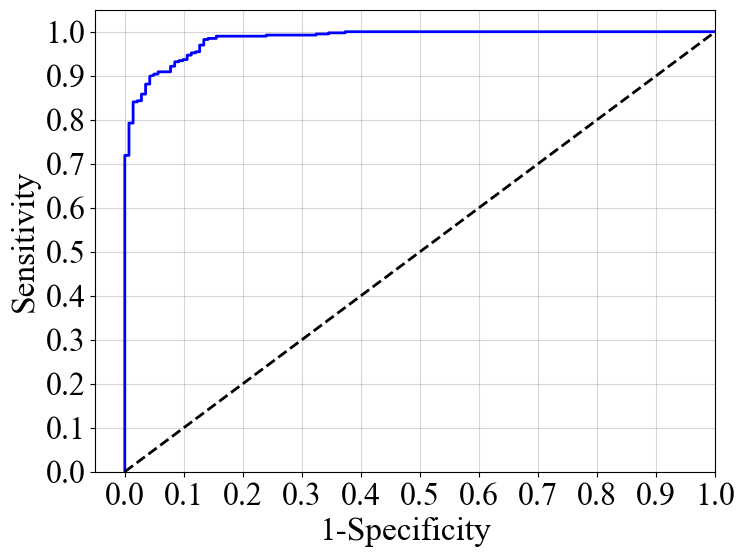

In [57]:
plt.figure(figsize=(8,6))
plt.rcParams['font.sans-serif'] = ['Times New Roman']

plt.plot(fpr, tpr, color='blue',
         lw=lw,  label='ROC\nAUC = %.2f\nACC = %.2f\nSEN = %.2f\nSPE = %.2f\nPPV = %.2f\nNPV = %.2f'% (
    roc_auc_test, test_accuracy,test_sensitivity, test_specificity, test_ppv, test_npv))
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0, 1.1, 0.1),fontsize=23)
plt.yticks(np.arange(0, 1.1, 0.1),fontsize=23)
plt.xlabel('1-Specificity',fontsize=24)
plt.ylabel('Sensitivity',fontsize=24)
#plt.title('ROC curve for Test ',fontsize=18)
plt.grid(True, alpha=0.5)
#plt.grid(False)
#plt.legend(handlelength=0,fontsize=20,framealpha=0.8,loc='lower right',facecolor='none',edgecolor='#2ca02c')
plt.savefig('D:\\yyzxrj\\project\\picture\\Test-roc.png',dpi=600,bbox_inches='tight')
plt.show()

<Figure size 800x600 with 0 Axes>

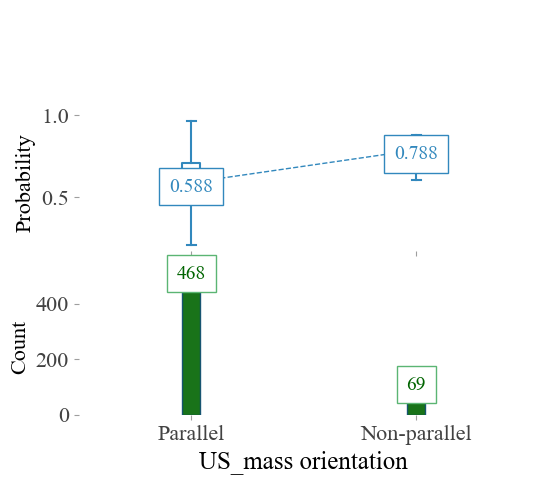

In [15]:
from pdpbox import info_plots
import matplotlib.pyplot as plt
import matplotlib


plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'


plt.figure(figsize=(8, 6))
custom_points = [1,2,3]
bin_labels = ['Parallel','Non-parallel']


fig, axes, summary_df = info_plots.actual_plot(
    model=classifier,
    X=x_train,
    feature='US_mass orientation',
    feature_name='US_mass orientation',
    predict_kwds={},
    cust_grid_points=custom_points
)

box_ax = axes['box_ax']
bar_ax = axes['bar_ax']
fig.suptitle('')


for ax_name, ax in axes.items():
    ax.set_title('')
    
    
    for text in ax.texts:
        if 'Actual predictions plot' in text.get_text() or 'Distribution of actual prediction' in text.get_text():
            text.set_text('')
            text.set_visible(False)


bar_ax.set_ylabel("Count", fontsize=16, fontfamily='Times New Roman')
box_ax.set_ylabel("Probability", fontsize=16, fontfamily='Times New Roman')


bar_ax.set_xlabel('US_mass orientation', fontsize=18, fontfamily='Times New Roman')
bar_ax.set_xticklabels(bin_labels, fontsize=16, fontfamily='Times New Roman')


for ax in [bar_ax, box_ax]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Times New Roman')


for text in bar_ax.texts:
    current_text = text.get_text()
    try:
        float(current_text)
        text.set_fontsize(14)
        text.set_color('#006400')
        x, y = text.get_position()
        text.set_position((x, y + 40))
    except ValueError:
        pass


box_ax.tick_params(axis='both', labelsize=16)
for text in box_ax.texts:
    text.set_fontsize(14)
    x, y = text.get_position()
    text.set_position((x, y + 0.03))


for bar in bar_ax.patches:
    bar.set_color('#006400')
    bar.set_edgecolor('#0a4a6e')
    bar.set_alpha(0.9)


bar_ax.set_xticklabels(bin_labels, fontsize=16)
bar_ax.tick_params(axis='y', labelsize=16)


plt.subplots_adjust(left=0.3, right=0.6, top=0.6, bottom=0.15)
box_ax.grid(False)
bar_ax.grid(False)
plt.savefig('D:\\yyzxrj\\project\\picture\\1.US_mass orientation.png',dpi=600,bbox_inches='tight')
plt.show()

<Figure size 800x600 with 0 Axes>

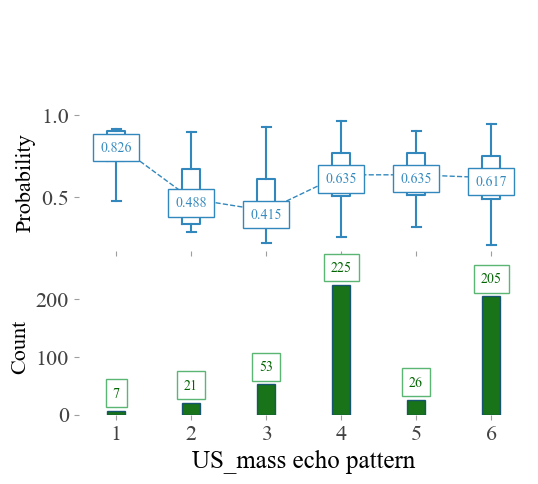

In [61]:
from pdpbox import info_plots
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Times New Roman'


plt.figure(figsize=(8, 6))

custom_points = [1, 2, 3, 4, 5, 6, 7]
bin_labels = ['1', '2', '3', '4', '5', '6']


fig, axes, summary_df = info_plots.actual_plot(
    model=classifier,
    X=x_train,
    feature='US_mass echo pattern',
    feature_name='US_mass echo pattern',
    predict_kwds={},
    cust_grid_points=custom_points
)

box_ax = axes['box_ax']
bar_ax = axes['bar_ax']
fig.suptitle('')


for ax_name, ax in axes.items():
    ax.set_title('')
    
    
    for text in ax.texts:
        if 'Actual predictions plot' in text.get_text() or 'Distribution of actual prediction' in text.get_text():
            text.set_visible(False)


bar_ax.set_ylabel("Count", fontsize=16, fontfamily='Times New Roman')
box_ax.set_ylabel("Probability", fontsize=16, fontfamily='Times New Roman')
bar_ax.set_xlabel('US_mass echo pattern', fontsize=18, fontfamily='Times New Roman')


bar_ax.set_xticklabels(bin_labels, fontsize=16, fontfamily='Times New Roman')


for ax in [bar_ax, box_ax]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Times New Roman')


for text in bar_ax.texts:
    current_text = text.get_text()
    try:
        float(current_text)
        text.set_fontsize(10)  
        text.set_color('#006400')
        text.set_fontfamily('Times New Roman')
       
        x, y = text.get_position()
        text.set_position((x, y + 30))
    except ValueError:
        pass


box_ax.tick_params(axis='both', labelsize=16)
for text in box_ax.texts:
    text.set_fontsize(10)  
    text.set_fontfamily('Times New Roman')
    x, y = text.get_position()
    text.set_position((x, y + 0.02))


for bar in bar_ax.patches:
    bar.set_color('#006400')
    bar.set_edgecolor('#0a4a6e')
    bar.set_alpha(0.9)


bar_ax.tick_params(axis='y', labelsize=16)


plt.subplots_adjust(left=0.3, right=0.6, top=0.6, bottom=0.15)
box_ax.grid(False)
bar_ax.grid(False)


plt.savefig('D:\\yyzxrj\\project\\picture\\2.US_mass echo pattern.png', dpi=600, bbox_inches='tight')
plt.show()

<Figure size 800x600 with 0 Axes>

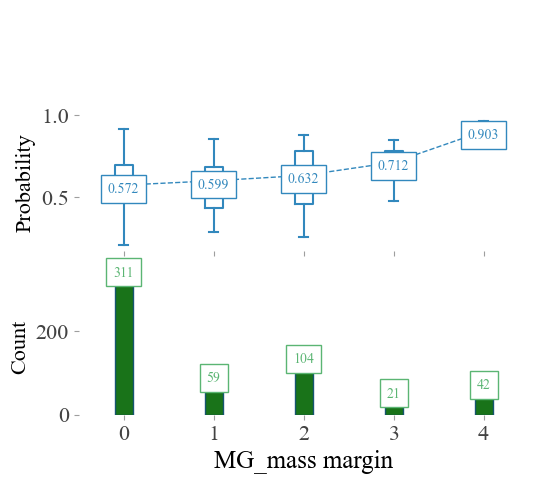

In [63]:
from pdpbox import info_plots
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Times New Roman'


plt.figure(figsize=(8, 6))

custom_points = [0, 1, 2, 3, 4, 5, 6]
bin_labels = ['0', '1', '2', '3', '4']


fig, axes, summary_df = info_plots.actual_plot(
    model=classifier,
    X=x_train,
    feature='MG_mass margin',
    feature_name='MG_mass margin',
    predict_kwds={},
    cust_grid_points=custom_points
)

box_ax = axes['box_ax']
bar_ax = axes['bar_ax']
fig.suptitle('')


for ax_name, ax in axes.items():
    ax.set_title('')
    
    
    for text in ax.texts:
        if 'Actual predictions plot' in text.get_text() or 'Distribution of actual prediction' in text.get_text():
            text.set_visible(False)


bar_ax.set_ylabel("Count", fontsize=16, fontfamily='Times New Roman')
box_ax.set_ylabel("Probability", fontsize=16, fontfamily='Times New Roman')
bar_ax.set_xlabel('MG_mass margin', fontsize=18, fontfamily='Times New Roman')


bar_ax.set_xticklabels(bin_labels, fontsize=16, fontfamily='Times New Roman')

for ax in [bar_ax, box_ax]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Times New Roman')


for text in bar_ax.texts:
    current_text = text.get_text()
    try:
        float(current_text)
        text.set_fontsize(10)  
        text.set_fontfamily('Times New Roman')
     
        x, y = text.get_position()
        text.set_position((x, y + 30))
    except ValueError:
        pass


box_ax.tick_params(axis='both', labelsize=16)
for text in box_ax.texts:
    text.set_fontsize(10)  
    text.set_fontfamily('Times New Roman')
    x, y = text.get_position()
    text.set_position((x, y + 0.02))

for bar in bar_ax.patches:
    bar.set_color('#006400')
    bar.set_edgecolor('#0a4a6e')
    bar.set_alpha(0.9)


bar_ax.tick_params(axis='y', labelsize=16)


plt.subplots_adjust(left=0.3, right=0.6, top=0.6, bottom=0.15)
box_ax.grid(False)
bar_ax.grid(False)

plt.savefig('D:\\yyzxrj\\project\\picture\\3.MG_mass margin.png', dpi=600, bbox_inches='tight')
plt.show()

<Figure size 800x600 with 0 Axes>

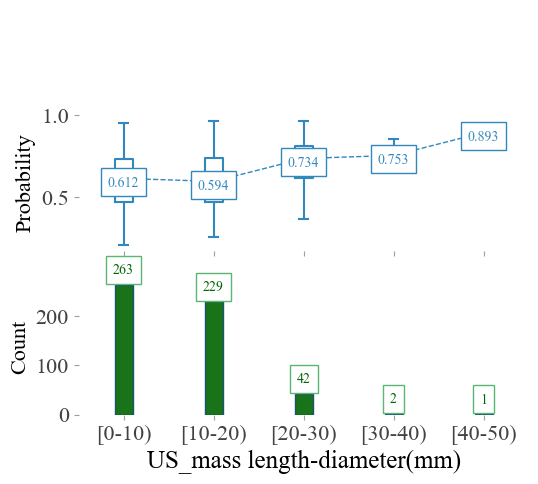

In [17]:
from pdpbox import info_plots
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Times New Roman'


plt.figure(figsize=(8, 6))

custom_points = [0, 10, 20, 30, 40, 50]
bin_labels = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)']


fig, axes, summary_df = info_plots.actual_plot(
    model=classifier,
    X=x_train,
    feature='US_mass length-diameter(mm)',
    feature_name='US_mass length-diameter(mm)',
    predict_kwds={},
    cust_grid_points=custom_points
)

box_ax = axes['box_ax']
bar_ax = axes['bar_ax']
fig.suptitle('')


for ax_name, ax in axes.items():
    ax.set_title('')
    
    
    for text in ax.texts:
        if 'Actual predictions plot' in text.get_text() or 'Distribution of actual prediction' in text.get_text():
            text.set_visible(False)


bar_ax.set_ylabel("Count", fontsize=16, fontfamily='Times New Roman')
box_ax.set_ylabel("Probability", fontsize=16, fontfamily='Times New Roman')
bar_ax.set_xlabel('US_mass length-diameter(mm)', fontsize=18, fontfamily='Times New Roman')


bar_ax.set_xticklabels(bin_labels, fontsize=16, fontfamily='Times New Roman')


for ax in [bar_ax, box_ax]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Times New Roman')


for text in bar_ax.texts:
    current_text = text.get_text()
    try:
        float(current_text)
        text.set_fontsize(10)  
        text.set_color('#006400')
        text.set_fontfamily('Times New Roman')
       
        x, y = text.get_position()
        text.set_position((x, y + 30))
    except ValueError:
        pass


box_ax.tick_params(axis='both', labelsize=16)
for text in box_ax.texts:
    text.set_fontsize(10)  
    text.set_fontfamily('Times New Roman')
    x, y = text.get_position()
    text.set_position((x, y + 0.02))

for bar in bar_ax.patches:
    bar.set_color('#006400')
    bar.set_edgecolor('#0a4a6e')
    bar.set_alpha(0.9)


bar_ax.tick_params(axis='y', labelsize=16)


plt.subplots_adjust(left=0.3, right=0.6, top=0.6, bottom=0.15)
box_ax.grid(False)
bar_ax.grid(False)


plt.savefig('D:\\yyzxrj\\project\\picture\\4.US_mass length-diameter (mm).png', dpi=600, bbox_inches='tight')
plt.show()

<Figure size 800x600 with 0 Axes>

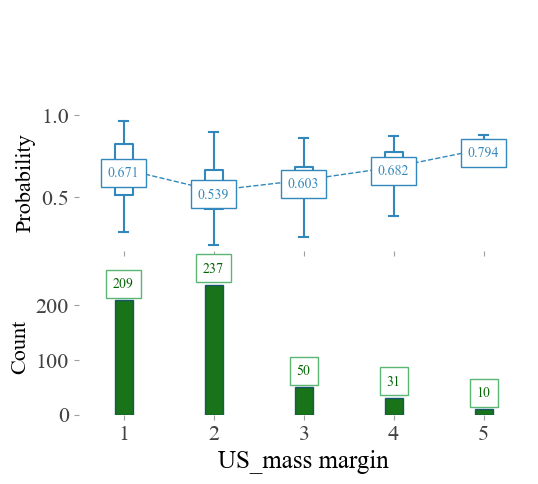

In [67]:
from pdpbox import info_plots
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Times New Roman'


plt.figure(figsize=(8, 6))

custom_points = [1, 2, 3, 4, 5, 6]
bin_labels = ['1', '2', '3', '4', '5']


fig, axes, summary_df = info_plots.actual_plot(
    model=classifier,
    X=x_train,
    feature='US_mass margin',
    feature_name='US_mass margin',
    predict_kwds={},
    cust_grid_points=custom_points
)

box_ax = axes['box_ax']
bar_ax = axes['bar_ax']
fig.suptitle('')


for ax_name, ax in axes.items():
    ax.set_title('')
    
   
    for text in ax.texts:
        if 'Actual predictions plot' in text.get_text() or 'Distribution of actual prediction' in text.get_text():
            text.set_visible(False)


bar_ax.set_ylabel("Count", fontsize=16, fontfamily='Times New Roman')
box_ax.set_ylabel("Probability", fontsize=16, fontfamily='Times New Roman')
bar_ax.set_xlabel('US_mass margin', fontsize=18, fontfamily='Times New Roman')


bar_ax.set_xticklabels(bin_labels, fontsize=16, fontfamily='Times New Roman')


for ax in [bar_ax, box_ax]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Times New Roman')


for text in bar_ax.texts:
    current_text = text.get_text()
    try:
        float(current_text)
        text.set_fontsize(10)  
        text.set_color('#006400')
        text.set_fontfamily('Times New Roman')
    
        x, y = text.get_position()
        text.set_position((x, y + 30))
    except ValueError:
        pass


box_ax.tick_params(axis='both', labelsize=16)
for text in box_ax.texts:
    text.set_fontsize(10)  
    text.set_fontfamily('Times New Roman')
    x, y = text.get_position()
    text.set_position((x, y + 0.02))


for bar in bar_ax.patches:
    bar.set_color('#006400')
    bar.set_edgecolor('#0a4a6e')
    bar.set_alpha(0.9)


bar_ax.tick_params(axis='y', labelsize=16)


plt.subplots_adjust(left=0.3, right=0.6, top=0.6, bottom=0.15)
box_ax.grid(False)
bar_ax.grid(False)


plt.savefig('D:\\yyzxrj\\project\\picture\\5.US_mass margin.png', dpi=600, bbox_inches='tight')
plt.show()

<Figure size 800x600 with 0 Axes>

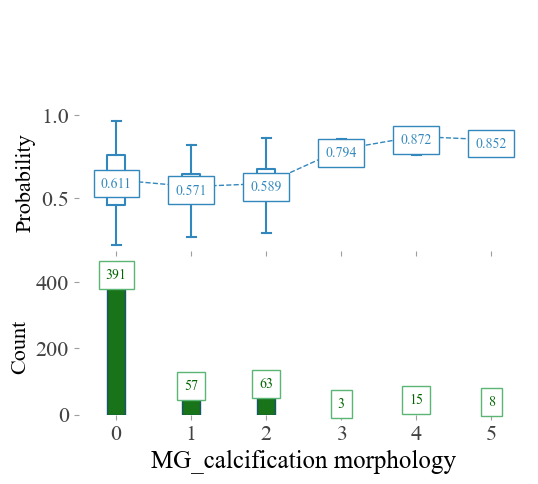

In [69]:
from pdpbox import info_plots
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Times New Roman'


plt.figure(figsize=(8, 6))

custom_points = [0, 1, 2, 3, 4, 5, 6]
bin_labels = ['0', '1', '2', '3', '4', '5']

fig, axes, summary_df = info_plots.actual_plot(
    model=classifier,
    X=x_train,
    feature='MG_calcification morphology',
    feature_name='MG_calcification morphology',
    predict_kwds={},
    cust_grid_points=custom_points
)

box_ax = axes['box_ax']
bar_ax = axes['bar_ax']
fig.suptitle('')

for ax_name, ax in axes.items():
    ax.set_title('')
    
   
    for text in ax.texts:
        if 'Actual predictions plot' in text.get_text() or 'Distribution of actual prediction' in text.get_text():
            text.set_visible(False)


bar_ax.set_ylabel("Count", fontsize=16, fontfamily='Times New Roman')
box_ax.set_ylabel("Probability", fontsize=16, fontfamily='Times New Roman')
bar_ax.set_xlabel('MG_calcification morphology', fontsize=18, fontfamily='Times New Roman')


bar_ax.set_xticklabels(bin_labels, fontsize=16, fontfamily='Times New Roman')


for ax in [bar_ax, box_ax]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Times New Roman')


for text in bar_ax.texts:
    current_text = text.get_text()
    try:
        float(current_text)
        text.set_fontsize(10)  
        text.set_color('#006400')
        text.set_fontfamily('Times New Roman')
        
        x, y = text.get_position()
        text.set_position((x, y + 30))
    except ValueError:
        pass

box_ax.tick_params(axis='both', labelsize=16)
for text in box_ax.texts:
    text.set_fontsize(10) 
    text.set_fontfamily('Times New Roman')
    x, y = text.get_position()
    text.set_position((x, y + 0.02))


for bar in bar_ax.patches:
    bar.set_color('#006400')
    bar.set_edgecolor('#0a4a6e')
    bar.set_alpha(0.9)


bar_ax.tick_params(axis='y', labelsize=16)


plt.subplots_adjust(left=0.3, right=0.6, top=0.6, bottom=0.15)
box_ax.grid(False)
bar_ax.grid(False)


plt.savefig('D:\\yyzxrj\\project\\picture\\6.MG_calcification morphology.png', dpi=600, bbox_inches='tight')
plt.show()

<Figure size 800x600 with 0 Axes>

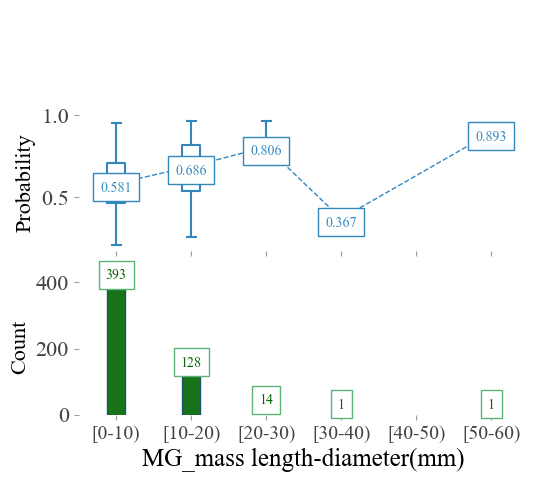

In [77]:
from pdpbox import info_plots
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Times New Roman'


plt.figure(figsize=(8, 6))

custom_points = [0, 10, 20, 30, 40, 50, 60]
bin_labels = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)']


fig, axes, summary_df = info_plots.actual_plot(
    model=classifier,
    X=x_train,
    feature='MG_mass length-diameter(mm)',
    feature_name='MG_mass length-diameter(mm)',
    predict_kwds={},
    cust_grid_points=custom_points
)

box_ax = axes['box_ax']
bar_ax = axes['bar_ax']
fig.suptitle('')


for ax_name, ax in axes.items():
    ax.set_title('')
    

    for text in ax.texts:
        if 'Actual predictions plot' in text.get_text() or 'Distribution of actual prediction' in text.get_text():
            text.set_visible(False)


bar_ax.set_ylabel("Count", fontsize=16, fontfamily='Times New Roman')
box_ax.set_ylabel("Probability", fontsize=16, fontfamily='Times New Roman')
bar_ax.set_xlabel('MG_mass length-diameter(mm)', fontsize=18, fontfamily='Times New Roman')


bar_ax.set_xticklabels(bin_labels, fontsize=14, fontfamily='Times New Roman')


for ax in [bar_ax, box_ax]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Times New Roman')


for text in bar_ax.texts:
    current_text = text.get_text()
    try:
        float(current_text)
        text.set_fontsize(10) 
        text.set_color('#006400')
        text.set_fontfamily('Times New Roman')

        x, y = text.get_position()
        text.set_position((x, y + 30))
    except ValueError:
        pass


box_ax.tick_params(axis='both', labelsize=16)
for text in box_ax.texts:
    text.set_fontsize(10)  # 缩小字体大小
    text.set_fontfamily('Times New Roman')
    x, y = text.get_position()
    text.set_position((x, y + 0.02))


for bar in bar_ax.patches:
    bar.set_color('#006400')
    bar.set_edgecolor('#0a4a6e')
    bar.set_alpha(0.9)


bar_ax.tick_params(axis='y', labelsize=16)


plt.subplots_adjust(left=0.3, right=0.6, top=0.6, bottom=0.15)
box_ax.grid(False)
bar_ax.grid(False)


plt.savefig('D:\\yyzxrj\\project\\picture\\7.MG_mass length-diameter.png', dpi=600, bbox_inches='tight')
plt.show()

<Figure size 800x600 with 0 Axes>

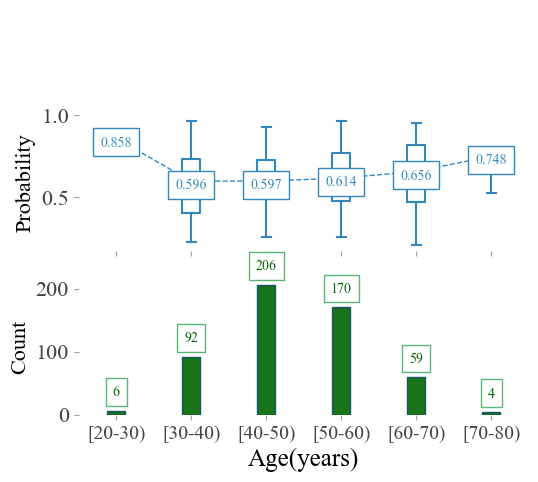

In [83]:
from pdpbox import info_plots
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Times New Roman'


plt.figure(figsize=(8, 6))

custom_points = [20, 30, 40, 50, 60, 70, 80]
bin_labels = ['[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)']


fig, axes, summary_df = info_plots.actual_plot(
    model=classifier,
    X=x_train,
    feature='Age(years)',
    feature_name='Age(years)',
    predict_kwds={},
    cust_grid_points=custom_points
)

box_ax = axes['box_ax']
bar_ax = axes['bar_ax']
fig.suptitle('')


for ax_name, ax in axes.items():
    ax.set_title('')
    
 
    for text in ax.texts:
        if 'Actual predictions plot' in text.get_text() or 'Distribution of actual prediction' in text.get_text():
            text.set_visible(False)


bar_ax.set_ylabel("Count", fontsize=16, fontfamily='Times New Roman')
box_ax.set_ylabel("Probability", fontsize=16, fontfamily='Times New Roman')
bar_ax.set_xlabel('Age(years)', fontsize=18, fontfamily='Times New Roman')


bar_ax.set_xticklabels(bin_labels, fontsize=14, fontfamily='Times New Roman')


for ax in [bar_ax, box_ax]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Times New Roman')


for text in bar_ax.texts:
    current_text = text.get_text()
    try:
        float(current_text)
        text.set_fontsize(10)  
        text.set_color('#006400')
        text.set_fontfamily('Times New Roman')
     
        x, y = text.get_position()
        text.set_position((x, y + 30))
    except ValueError:
        pass


box_ax.tick_params(axis='both', labelsize=16)
for text in box_ax.texts:
    text.set_fontsize(10)  
    text.set_fontfamily('Times New Roman')
    x, y = text.get_position()
    text.set_position((x, y + 0.02))

for bar in bar_ax.patches:
    bar.set_color('#006400')
    bar.set_edgecolor('#0a4a6e')
    bar.set_alpha(0.9)


bar_ax.tick_params(axis='y', labelsize=16)


plt.subplots_adjust(left=0.3, right=0.6, top=0.6, bottom=0.15)
box_ax.grid(False)
bar_ax.grid(False)


plt.savefig('D:\\yyzxrj\\project\\picture\\8.Age(years).png', dpi=600, bbox_inches='tight')
plt.show()

<Figure size 800x600 with 0 Axes>

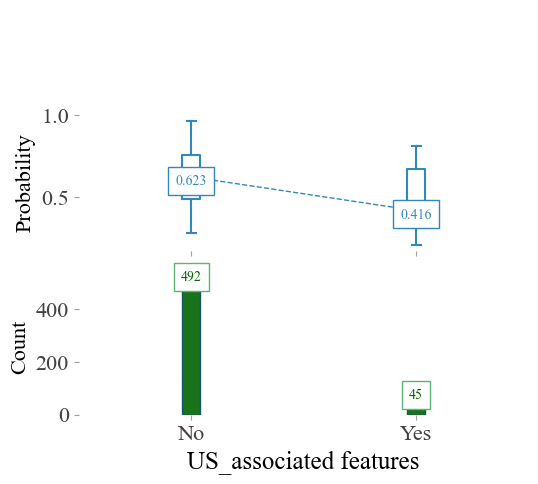

In [85]:
from pdpbox import info_plots
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Times New Roman'


plt.figure(figsize=(8, 6))

custom_points = [0, 1, 2]
bin_labels = ['No', 'Yes']


fig, axes, summary_df = info_plots.actual_plot(
    model=classifier,
    X=x_train,
    feature='US_associated features',
    feature_name='US_associated features',
    predict_kwds={},
    cust_grid_points=custom_points
)

box_ax = axes['box_ax']
bar_ax = axes['bar_ax']
fig.suptitle('')


for ax_name, ax in axes.items():
    ax.set_title('')
    
   
    for text in ax.texts:
        if 'Actual predictions plot' in text.get_text() or 'Distribution of actual prediction' in text.get_text():
            text.set_visible(False)


bar_ax.set_ylabel("Count", fontsize=16, fontfamily='Times New Roman')
box_ax.set_ylabel("Probability", fontsize=16, fontfamily='Times New Roman')
bar_ax.set_xlabel('US_associated features', fontsize=18, fontfamily='Times New Roman')


bar_ax.set_xticklabels(bin_labels, fontsize=16, fontfamily='Times New Roman')


for ax in [bar_ax, box_ax]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Times New Roman')


for text in bar_ax.texts:
    current_text = text.get_text()
    try:
        float(current_text)
        text.set_fontsize(10)  
        text.set_color('#006400')
        text.set_fontfamily('Times New Roman')
      
        x, y = text.get_position()
        text.set_position((x, y + 30))
    except ValueError:
        pass

box_ax.tick_params(axis='both', labelsize=16)
for text in box_ax.texts:
    text.set_fontsize(10)  
    text.set_fontfamily('Times New Roman')
    x, y = text.get_position()
    text.set_position((x, y + 0.02))

for bar in bar_ax.patches:
    bar.set_color('#006400')
    bar.set_edgecolor('#0a4a6e')
    bar.set_alpha(0.9)


bar_ax.tick_params(axis='y', labelsize=16)


plt.subplots_adjust(left=0.3, right=0.6, top=0.6, bottom=0.15)
box_ax.grid(False)
bar_ax.grid(False)


plt.savefig('D:\\yyzxrj\\project\\picture\\9.US_associated features.png', dpi=600, bbox_inches='tight')
plt.show()

In [93]:
dataFile = 'D:\\yyzxrj\\project\\Training dataset for running.xlsx'
data = pd.read_excel(dataFile)
data = pd.read_excel(dataFile).iloc[:, 1:-1]

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec



plt.rcParams['font.sans-serif']= ['Times New Roman']    
plt.rcParams['axes.unicode_minus'] = False

front_features = data.columns[:10]  
back_features = data.columns[10:]   



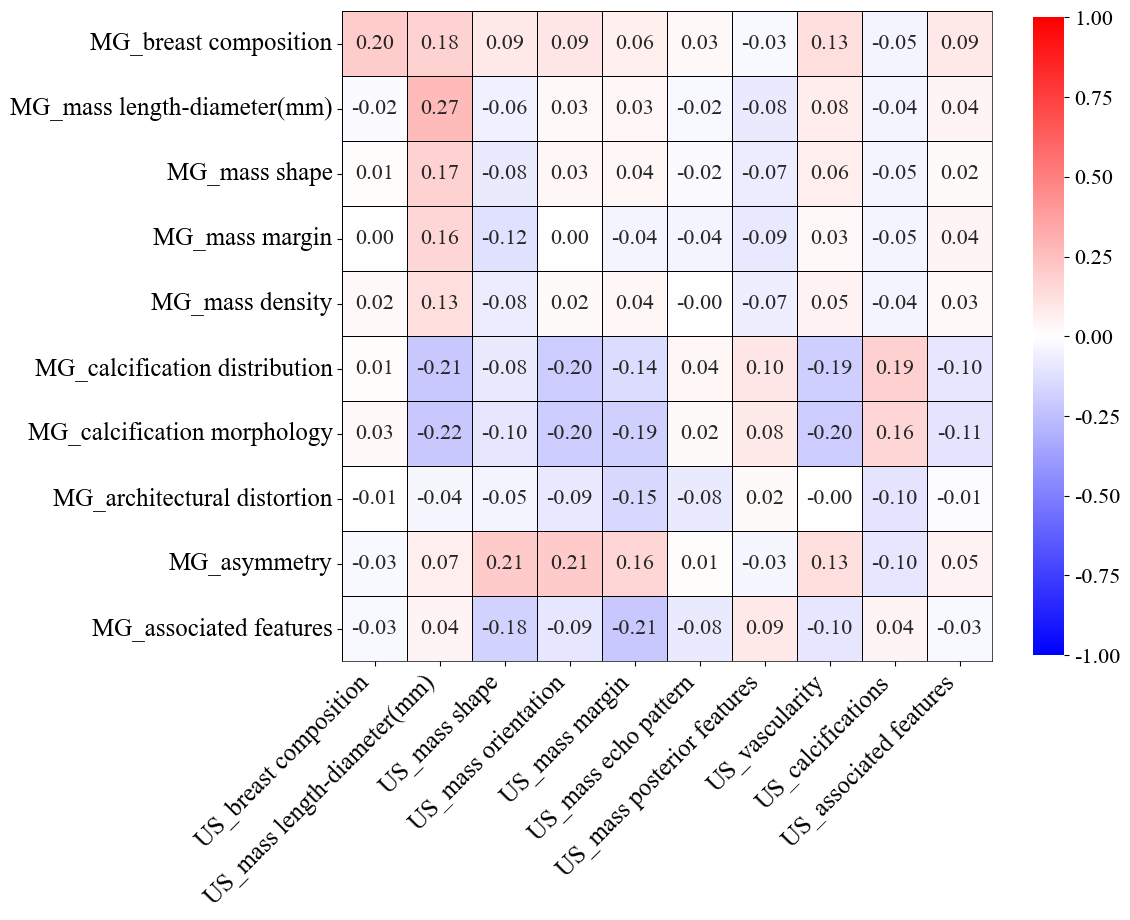

In [97]:
corr_matrix = pd.DataFrame(index=front_features, columns=back_features)

for front_feat in front_features:
    for back_feat in back_features:
        
        corr = data[front_feat].corr(data[back_feat], method='spearman')
        corr_matrix.loc[front_feat, back_feat] = corr


corr_matrix = corr_matrix.astype(float)


plt.rcParams['font.family'] = ['Times New Roman']
fig, ax = plt.subplots(figsize=(12, 10))


heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    linecolor='black',
    cmap='bwr',
    center=0,
    square=True,
    cbar_kws={"shrink": 0.9},
    annot_kws={"size": 16},
    vmin=-1.0, 
    vmax=1.0,   
    ax=ax
)


for spine in ax.spines.values():
    spine.set_visible(True)  
    spine.set_edgecolor('black')  
    spine.set_linewidth(0.5) 
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  

plt.yticks(rotation=0, fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.tight_layout(pad=2.0)

plt.savefig('D:\\yyzxrj\\project\\picture\\Spearman.png',dpi=600,bbox_inches='tight')
plt.show()

In [ ]:
import joblib
import shap

shap.initjs()
classifier = joblib.load('rfc.pkl')
data = pd.read_excel('Training dataset for running.xlsx')
x_train = data.iloc[:,0:-1]
y_train = data.iloc[:,-1]

data1 = pd.read_excel('External test set for running.xlsx')
x_test = data1.iloc[:,0:-1]
y_test = data1.iloc[:,-1]

In [ ]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(x_train,y_train)[:,:,1]

plt.figure(figsize=(8,6))
figure = shap.summary_plot(shap_values, x_train, plot_type='bar',max_display=21, show=False)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.xlabel('Mean(|SHAP Value|)')
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_6-1.png", dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(8,6))
figure = shap.summary_plot(shap_values, x_train,max_display=21, show=False)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.xlabel('SHAP Value')
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_6-2.png", dpi=600, bbox_inches='tight')

In [ ]:
shap_values_summary = explainer.shap_values(x_test)
shap.force_plot(explainer.expected_value, shap_values_summary[:,:,1], x_test)

In [ ]:
shap_values = explainer.shap_values(x_train)

In [ ]:
plt.figure(figsize=(8,6))

figure = shap.decision_plot(explainer.expected_value[1], shap_values[:,:,1], x_test, show=False)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_9-1.png", dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(8,6))
y_pred = classifier.predict(x_test)
misclassified_indices = np.where(y_pred != y_test)[0]
misclassified = y_pred != y_test
misclassified_df = misclassified[misclassified==True]
figure = shap.decision_plot(explainer.expected_value[1],shap_values[misclassified_indices][:,:,1],x_test.iloc[misclassified_indices],highlight=misclassified_df, show=False)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_9-2.png", dpi=600, bbox_inches='tight')

In [ ]:
y_prob = classifier.predict_proba(x_train)[:,1]
plt.figure(figsize=(8,6))
shap_v = explainer(x_train)
order = np.argsort(y_prob)
figure = shap.plots.heatmap(shap_v[:,:,1], max_display=10, show=False)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_10.png", dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(8,6))
shap_interaction_values = explainer.shap_interaction_values(x_train)
figure = shap.summary_plot(shap_interaction_values[:,:,:,1], x_train,max_display=9, show=False)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_7.png", dpi=600, bbox_inches='tight')

In [ ]:
data = pd.read_excel(r"C:\Users\71915\Desktop\Training dataset.xlsx")

feature = data.iloc[:,14]
label = data.iloc[:,-1]
cross_tab = pd.crosstab(feature, label, normalize='columns')
fig = plt.subplots(figsize=(8, 6))
y0 = cross_tab[0].tolist()
y1 = cross_tab[1].tolist()
x = np.arange(len(np.unique(feature)))
width = 0.2

plt.bar(x - width/2, y0, width, label='no-benefit', color='#1f77b4')
plt.bar(x + width/2, y1, width, label='benefit',color='#ff7f0e')
plt.plot(x - width/2, y0, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x + width/2, y1, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x - width/2, y0, width, color='#1f77b4', linewidth=3)
plt.plot(x + width/2, y1, width, color='#ff7f0e', linewidth=3)
plt.plot(x - width/2, y0, 'ko', markersize=6)
plt.plot(x + width/2, y1, 'ko', markersize=6)
plt.xlabel("US mass orientation",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
plt.xticks([0,1],['0', '1'], rotation=0, fontsize=18)
plt.xlim([-1,2])
plt.yticks(fontsize=18)
plt.legend('')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.savefig(r"C:\Users\71915\Desktop\Figure_4-1.png", dpi=600, bbox_inches='tight')

In [ ]:
feature = data.iloc[:,16]
label = data.iloc[:,-1]
cross_tab = pd.crosstab(feature, label, normalize='columns')
fig = plt.subplots(figsize=(8, 6))
y0 = cross_tab[0].tolist()
y1 = cross_tab[1].tolist()
x = np.arange(1,len(np.unique(feature))+1)
width = 0.4

plt.bar(x - width/2, y0, width, label='no-benefit', color='#1f77b4')
plt.bar(x + width/2, y1, width, label='benefit',color='#ff7f0e')
plt.plot(x - width/2, y0, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x + width/2, y1, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x - width/2, y0, width, color='#1f77b4', linewidth=3)
plt.plot(x + width/2, y1, width, color='#ff7f0e', linewidth=3)
plt.plot(x - width/2, y0, 'ko', markersize=6)
plt.plot(x + width/2, y1, 'ko', markersize=6)
plt.xlabel("US mass echo pattern",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
plt.xticks([1,2,3,4,5,6],['1','2','3','4','5','6'],rotation=0,fontsize=18)
plt.xlim([0.3,6.7])
plt.yticks(fontsize=18)
plt.legend('')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_4-2.png", dpi=600, bbox_inches='tight')

In [ ]:
feature = data.iloc[:,4]
label = data.iloc[:,-1]
cross_tab = pd.crosstab(feature, label, normalize='columns')
fig = plt.subplots(figsize=(8, 6))
y0 = cross_tab[0].tolist()
y1 = cross_tab[1].tolist()
x = np.arange(len(np.unique(feature)))
width = 0.3

plt.bar(x - width/2, y0, width, label='no-benefit', color='#1f77b4')
plt.bar(x + width/2, y1, width, label='benefit',color='#ff7f0e')
plt.plot(x - width/2, y0, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x + width/2, y1, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x - width/2, y0, width, color='#1f77b4', linewidth=3)
plt.plot(x + width/2, y1, width, color='#ff7f0e', linewidth=3)
plt.plot(x - width/2, y0, 'ko', markersize=6)
plt.plot(x + width/2, y1, 'ko', markersize=6)
plt.xlabel("MG mass margin",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
plt.xticks([0,1,2,3,4],['0','1','2','3','4'],rotation=0,fontsize=18)

plt.yticks(fontsize=18)
plt.legend('')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_4-3.png", dpi=600, bbox_inches='tight')

In [ ]:
feature = data.iloc[:,12]
bi = [0, 10, 20, 30, 40, 50]
feature = pd.cut(feature, bi, right=False)
label = data.iloc[:,-1]
cross_tab = pd.crosstab(feature, label, normalize='columns')
fig = plt.subplots(figsize=(8, 6))
y0 = cross_tab[0].tolist()
y1 = cross_tab[1].tolist()
x = np.arange(len(np.unique(feature)))
width = 0.3

plt.bar(x - width/2, y0, width, label='no-benefit', color='#1f77b4')
plt.bar(x + width/2, y1, width, label='benefit',color='#ff7f0e')
plt.plot(x - width/2, y0, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x + width/2, y1, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x - width/2, y0, width, color='#1f77b4', linewidth=3)
plt.plot(x + width/2, y1, width, color='#ff7f0e', linewidth=3)
plt.plot(x - width/2, y0, 'ko', markersize=6)
plt.plot(x + width/2, y1, 'ko', markersize=6)
plt.xlabel("US mass length-diameter",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
plt.xticks([0,1,2,3,4],['A','B','C','D','E'],rotation=0,fontsize=18)
plt.yticks(fontsize=18)
plt.legend('')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_4-4.png", dpi=600, bbox_inches='tight')

In [ ]:
feature = data.iloc[:,15]
label = data.iloc[:,-1]
cross_tab = pd.crosstab(feature, label, normalize='columns')
fig = plt.subplots(figsize=(8, 6))
y0 = cross_tab[0].tolist()
y1 = cross_tab[1].tolist()
x = np.arange(len(np.unique(feature)))
width = 0.3

plt.bar(x - width/2, y0, width, label='no-benefit', color='#1f77b4')
plt.bar(x + width/2, y1, width, label='benefit',color='#ff7f0e')
plt.plot(x - width/2, y0, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x + width/2, y1, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x - width/2, y0, width, color='#1f77b4', linewidth=3)
plt.plot(x + width/2, y1, width, color='#ff7f0e', linewidth=3)
plt.plot(x - width/2, y0, 'ko', markersize=6)
plt.plot(x + width/2, y1, 'ko', markersize=6)
plt.xlabel("US mass margin",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
plt.xticks([0,1,2,3,4],['0', '1', '2', '3', '4'],rotation=0,fontsize=18)

plt.yticks(fontsize=18)
plt.legend('')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_4-5.png", dpi=600, bbox_inches='tight')

In [ ]:
feature = data.iloc[:,6]
label = data.iloc[:,-1]
cross_tab = pd.crosstab(feature, label, normalize='columns')
fig = plt.subplots(figsize=(8, 6))
y0 = cross_tab[0].tolist()
y1 = cross_tab[1].tolist()
x = np.arange(len(np.unique(feature)))
width = 0.4

plt.bar(x - width/2, y0, width, label='no-benefit', color='#1f77b4')
plt.bar(x + width/2, y1, width, label='benefit',color='#ff7f0e')
plt.plot(x - width/2, y0, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x + width/2, y1, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x - width/2, y0, width, color='#1f77b4', linewidth=3)
plt.plot(x + width/2, y1, width, color='#ff7f0e', linewidth=3)
plt.plot(x - width/2, y0, 'ko', markersize=6)
plt.plot(x + width/2, y1, 'ko', markersize=6)
plt.xlabel("MG calcification morphology",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
plt.xticks([0,1,2,3,4,5],['0', '1', '2', '3', '4','5'],rotation=0,fontsize=18)

plt.yticks(fontsize=18)
plt.legend('')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_4-6.png", dpi=600, bbox_inches='tight')

In [ ]:
feature = data.iloc[:,2]
bi = [0, 10, 20, 30, 40, 50, 60]
feature = pd.cut(feature, bi, right=False)
label = data.iloc[:,-1]
cross_tab = pd.crosstab(feature, label, normalize='columns')
fig = plt.subplots(figsize=(8, 6))
y0 = cross_tab[0].tolist()
y1 = cross_tab[1].tolist()
x = np.arange(len(np.unique(feature)))
width = 0.3

plt.bar(x - width/2, y0, width, label='no-benefit', color='#1f77b4')
plt.bar(x + width/2, y1, width, label='benefit',color='#ff7f0e')
plt.plot(x - width/2, y0, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x + width/2, y1, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x - width/2, y0, width, color='#1f77b4', linewidth=3)
plt.plot(x + width/2, y1, width, color='#ff7f0e', linewidth=3)
plt.plot(x - width/2, y0, 'ko', markersize=6)
plt.plot(x + width/2, y1, 'ko', markersize=6)
plt.xlabel("MG mass length-diameter",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
plt.xticks([0,1,2,3,4],['A','B','C','D','E',],rotation=0,fontsize=18)
plt.yticks(fontsize=18)
plt.legend('')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_4-7.png", dpi=600, bbox_inches='tight')

In [ ]:
feature = data.iloc[:,0]
bi = [20, 30, 40, 50, 60, 70, 80]
feature = pd.cut(feature, bi, right=False)
label = data.iloc[:,-1]
cross_tab = pd.crosstab(feature, label, normalize='columns')
fig = plt.subplots(figsize=(8, 6))
y0 = cross_tab[0].tolist()
y1 = cross_tab[1].tolist()
x = np.arange(len(np.unique(feature)))
width = 0.35

plt.bar(x - width/2, y0, width, label='no-benefit', color='#1f77b4')
plt.bar(x + width/2, y1, width, label='benefit',color='#ff7f0e')
plt.plot(x - width/2, y0, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x + width/2, y1, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x - width/2, y0, width, color='#1f77b4', linewidth=3)
plt.plot(x + width/2, y1, width, color='#ff7f0e', linewidth=3)
plt.plot(x - width/2, y0, 'ko', markersize=6)
plt.plot(x + width/2, y1, 'ko', markersize=6)
plt.xlabel("Age",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
plt.xticks([0,1,2,3,4,5],['A','B','C','D','E','F'],rotation=0,fontsize=18)
plt.yticks(fontsize=18)
plt.legend('')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_4-8.png", dpi=600, bbox_inches='tight')

In [ ]:
feature = data.iloc[:,-6]
label = data.iloc[:,-1]
cross_tab = pd.crosstab(feature, label, normalize='columns')
fig = plt.subplots(figsize=(8, 6))
y0 = cross_tab[0].tolist()
y1 = cross_tab[1].tolist()
x = np.arange(len(np.unique(feature)))
width = 0.2

plt.bar(x - width/2, y0, width, label='no-benefit', color='#1f77b4')
plt.bar(x + width/2, y1, width, label='benefit',color='#ff7f0e')
plt.plot(x - width/2, y0, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x + width/2, y1, width, color='black', linewidth=4, alpha=0.6)
plt.plot(x - width/2, y0, width, color='#1f77b4', linewidth=3)
plt.plot(x + width/2, y1, width, color='#ff7f0e', linewidth=3)
plt.plot(x - width/2, y0, 'ko', markersize=6)
plt.plot(x + width/2, y1, 'ko', markersize=6)
plt.xlabel("US associated features",fontsize=22)
plt.ylabel("Percentage",fontsize=22)
plt.xticks([0,1],['0', '1'],rotation=0,fontsize=18)
plt.xlim([-1,2])
plt.yticks(fontsize=18)
plt.legend('')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\Figure_4-9.png", dpi=600, bbox_inches='tight')

In [ ]:
import joblib
import shap

classifier = joblib.load('rfc.pkl')
data = pd.read_excel('train.xlsx')
x_train = data.iloc[:,0:-1]
y_train = data.iloc[:,-1]

data1 = pd.read_excel('val29.23.xlsx')
x_test = data1.iloc[:,0:-1]
y_test = data1.iloc[:,-1]

explainer = shap.TreeExplainer(classifier)
shap_values = explainer(x_train)

data = pd.read_excel(r"C:\Users\71915\Desktop\Training dataset.xlsx")

In [ ]:
plt.figure(figure=(8,6))
x = data.iloc[:,14]
List =[]
for i in x:
    List.append(i + np.random.normal(0,0.05,1))
y = shap_values[:,:,1][:,14].values
plt.scatter(x, y, marker='o', c='cyan', edgecolors='k', alpha=0.8, linewidths=1)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.xlabel("US mass orientation",fontsize=15)
plt.ylabel("SHAP Values",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xticks([1,2])
plt.xlim([0.5,2.5])
plt.axhline(y=0, color='black', linestyle='-.', linewidth=1)  
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\1-1.png", dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figure=(8,6))
x = data.iloc[:,16]
List =[]
for i in x:
    List.append(i + np.random.normal(0,0.05,1))
y = shap_values[:,:,1][:,16].values
plt.scatter(x, y, marker='o', c='cyan', edgecolors='k', alpha=0.8, linewidths=1)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.xlabel("US mass echo pattern",fontsize=15)
plt.ylabel("SHAP Values",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axhline(y=0, color='black', linestyle='-.', linewidth=1)  
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\1-2.png", dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figure=(8,6))
x = data.iloc[:,4]
List =[]
for i in x:
    List.append(i + np.random.normal(0,0.05,1))
y = shap_values[:,:,1][:,4].values
plt.scatter(x, y, marker='o', c='cyan', edgecolors='k', alpha=0.8, linewidths=1)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.xlabel("MG mass margin",fontsize=15)
plt.ylabel("SHAP Values",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xticks([0,1,2,3,4])
plt.axhline(y=0, color='black', linestyle='-.', linewidth=1)  
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\1-3.png", dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figure=(8,6))
x = data.iloc[:,12]
y = shap_values[:,:,1][:,12].values
plt.scatter(x, y, marker='o', c='cyan', edgecolors='k', alpha=0.8, linewidths=1)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.xlabel("US mass length-diameter(mm)",fontsize=15)
plt.ylabel("SHAP Values",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axhline(y=0, color='black', linestyle='-.', linewidth=1)  
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\1-4.png", dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figure=(8,6))
x = data.iloc[:,15]
List =[]
for i in x:
    List.append(i + np.random.normal(0,0.05,1))
y = shap_values[:,:,1][:,15].values
plt.scatter(x, y, marker='o', c='cyan', edgecolors='k', alpha=0.8, linewidths=1)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.xlabel("US mass margin",fontsize=15)
plt.ylabel("SHAP Values",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axhline(y=0, color='black', linestyle='-.', linewidth=1)  
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\1-5.png", dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figure=(8,6))
x = data.iloc[:,6]
List =[]
for i in x:
    List.append(i + np.random.normal(0,0.05,1))
y = shap_values[:,:,1][:,6].values
plt.scatter(x, y, marker='o', c='cyan', edgecolors='k', alpha=0.8, linewidths=1)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.xlabel("MG calcification morphology",fontsize=15)
plt.ylabel("SHAP Values",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axhline(y=0, color='black', linestyle='-.', linewidth=1)  
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\1-6.png", dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figure=(8,6))
x = data.iloc[:,2]
y = shap_values[:,:,1][:,2].values
plt.scatter(x, y, marker='o', c='cyan', edgecolors='k', alpha=0.8, linewidths=1)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.xlabel("MG mass length-diameter(mm)",fontsize=15)
plt.ylabel("SHAP Values",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axhline(y=0, color='black', linestyle='-.', linewidth=1)  
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\1-7.png", dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figure=(8,6))
x = data.iloc[:,0]
y = shap_values[:,:,1][:,0].values
plt.scatter(x, y, marker='o', c='cyan', edgecolors='k', alpha=0.8, linewidths=1)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.xlabel("Age(years)",fontsize=15)
plt.ylabel("SHAP Values",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axhline(y=0, color='black', linestyle='-.', linewidth=1)  
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\1-8.png", dpi=600, bbox_inches='tight')

In [ ]:
plt.figure(figure=(8,6))
x = data.iloc[:,-6]
List =[]
for i in x:
    List.append(i + np.random.normal(0,0.05,1))
y = shap_values[:,:,1][:,-6].values
plt.scatter(x, y, marker='o', c='cyan', edgecolors='k', alpha=0.8, linewidths=1)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.xlabel("US assosiated features",fontsize=15)
plt.ylabel("SHAP Values",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xticks([0,1])
plt.xlim([-0.5,1.5])
plt.axhline(y=0, color='black', linestyle='-.', linewidth=1)  
plt.tight_layout()
plt.savefig(r"C:\Users\71915\Desktop\1-9.png", dpi=600, bbox_inches='tight')